In [1]:
import os
import pandas as pd
import numpy as np
import yaml
import logging
import pickle
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from utilities.utilities import read_ac_data, add_gdp_cdd_data
from utilities.plotting import plot_exposure_contour

In [2]:
# Load configuration from config.yaml
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)

# Set logging level
logging.basicConfig(level=config["logging_level"])

if not os.path.exists('Figures/exposure_function') :
    os.makedirs('Figures/exposure_function')

In [3]:
# Read the air conditioning data from the EIA and GDL

# EIA data of AC access from 2018
ac_data_eia = read_ac_data(config['ac_historical_file_iea'], 2018, skip=3)

# GDL data from multiple years
ac_data_gdl = read_ac_data(config['ac_historical_file_gdl'])

# Read OECD data
ac_data_oecd = read_ac_data(config['ac_historical_file_oecd'], 2011)

# Merge the two dataframes
ac_data = pd.concat([ac_data_oecd, ac_data_gdl, ac_data_eia])

ac_data = add_gdp_cdd_data(ac_data, config)

ac_data["GDP"] = pd.to_numeric(ac_data["GDP"], errors='coerce')

# If there are multiple entries for the same country, only keep the latest one
ac_data = ac_data.drop_duplicates('ISO3', keep='last')
ac_data = ac_data.dropna()

# Save the data to a csv file
ac_data.to_csv("air_conditioning_data.csv")

# Prepare xdata as a tuple of CDD and GDP, ydata as AC
xdata = (ac_data["CDD"]/1000., ac_data["GDP"]/100000.)
ydata = ac_data["AC"]


In [4]:
# AC access function with values from paper
def ac_access_paper(xdata):
    cdd, gdp = xdata
    return (1. - 0.949*np.exp(-0.00187 * cdd)) * (1 / (1 + np.exp(4.152) * np.exp(-0.237 * gdp/1000.)))

# Functional form of AC access function
def ac_access_paper_refit(xdata, a, b, c):
    cdd, gdp = xdata
    return ((1. - np.exp(-a * cdd)) * (1 / (1 + np.exp(b) * np.exp(-c * gdp))))

def ac_access_combined_exp(xdata, a, b, c):
    cdd, gdp = xdata
    return (np.exp(-a * ((cdd)**(b) * (gdp)**c)))

In [5]:
# Calculate the R^2 and RMSE value
def calc_r2_rmse(ydata, ymodel):
    from sklearn.metrics import r2_score, mean_squared_error
    r2 = r2_score(ydata, ymodel)
    rmse = np.sqrt(mean_squared_error(ydata, ymodel))
    print("R^2: ", r2)
    print("RMSE: ", rmse)
    # Calculate the residuals
    residuals = ydata - ymodel
    # Calculate R2 and RSME step by step
    ss_res = np.sum(residuals**2)
    print("SS_res: ", ss_res)
    ss_tot = np.sum((ydata - np.mean(ydata))**2)
    print("SS_tot: ", ss_tot)
    r2_step = 1 - ss_res/ss_tot
    print("len ydata: ", len(ydata))
    rmse_step = np.sqrt(ss_res/len(ydata))
    print("R^2 step: ", r2_step)
    print("RMSE step: ", rmse_step)

    # Calculate and adjusted R2
    n = len(ydata)
    p = 3
    r2_adj = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    print("Adjusted R^2: ", r2_adj)
    return r2, rmse

In [6]:
# Plot AC access data vs model
def plot_ac_access(ydata, ymodel, color, title, filename):
    plt.figure()
    plt.scatter(ydata, ymodel, color=color)
    plt.plot([0.001, 1], [0.001, 1], color='gray', linestyle='--')
    # Both axes in log scale
    plt.xscale('log')
    plt.yscale('log')
    # Set the limits of the axes
    plt.xlim([0.001, 1])
    plt.ylim([0.001, 1])
    # Add labels
    plt.xlabel("AC access data")
    plt.ylabel("AC access model")
    plt.title(title)
    plt.savefig("Figures/exposure_function/{0}.png".format(filename))

R^2:  0.2674010378060383
RMSE:  0.1980627775755193
SS_res:  2.981393653430652
SS_tot:  4.069612171578948
len ydata:  76
R^2 step:  0.2674010378060383
RMSE step:  0.1980627775755193
Adjusted R^2:  0.23687608104795654


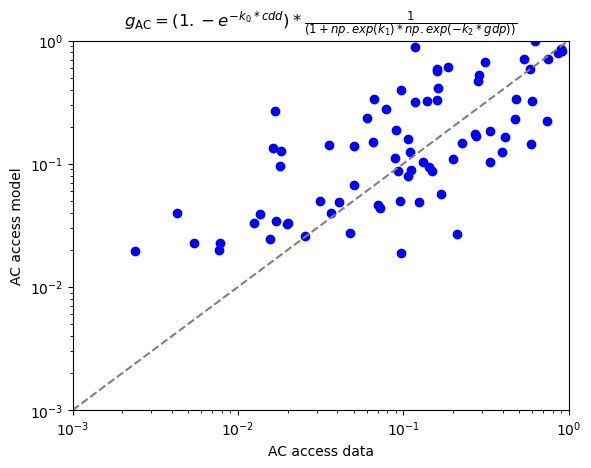

In [7]:
# Paper model with parameter values from paper
calc_r2_rmse(ydata, ac_access_paper((ac_data["CDD"], ac_data["GDP"])))
plot_ac_access(ydata, ac_access_paper((ac_data["CDD"], ac_data["GDP"])), "blue",r"$g_{\mathrm{AC}}=(1. - e^{-k_0 * cdd}) * \frac{1}{(1 + np.exp(k_1) * np.exp(-k_2 * gdp))}$", "ac_access_paper")

[4.36775527 2.57860165 8.21963777]
R^2:  0.5801283342289195
RMSE:  0.14994362280550985
SS_res:  1.708714841523117
SS_tot:  4.069612171578948
len ydata:  76
R^2 step:  0.5801283342289195
RMSE step:  0.14994362280550985
Adjusted R^2:  0.5626336814884578


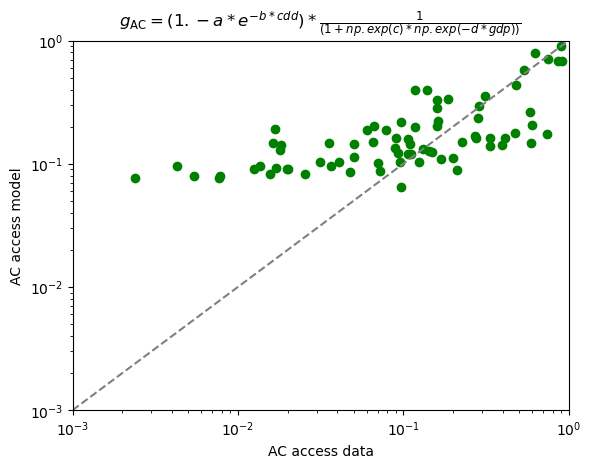

In [8]:
# Fit the paper function to new data
ydata = ((ac_data["AC"]))
popt, pcov = curve_fit(ac_access_paper_refit, xdata, ydata)

print(popt)

# Calculate the R^2 and RMSE value
calc_r2_rmse(ac_data["AC"], ac_access_paper_refit(xdata, *popt))
# Plot the AC access data vs model
plot_ac_access(ac_data["AC"], (ac_access_paper_refit(xdata, *popt)), "green", r"$g_{\mathrm{AC}}=(1. - a*e^{-b * cdd}) * \frac{1}{(1 + np.exp(c) * np.exp(-d * gdp))}$", "ac_access_paper_new_fit")

# Save the parameters to a pickle file to use for plotting
with open('exposure_function_params_exponential.pkl', 'wb') as f:
    pickle.dump({'cdd_scale': popt[0], 'alpha': popt[1], 'k': popt[2]}, f)

[1.51981765e+00 1.48948296e-01 4.36307054e-18]
R^2:  0.053538009972745715
RMSE:  0.22512374475969488
SS_res:  3.8517332345517468
SS_tot:  4.069612171578948
len ydata:  76
R^2 step:  0.053538009972745715
RMSE step:  0.22512374475969488
Adjusted R^2:  0.014102093721610198


[9.7876265  0.81268086 1.02803298 7.00902134]
R^2:  0.585323130828848
RMSE:  0.1490131588171773
SS_res:  1.6875740340511713
SS_tot:  4.069612171578948
len ydata:  76
R^2 step:  0.585323130828848
RMSE step:  0.1490131588171773
Adjusted R^2:  0.5680449279467167


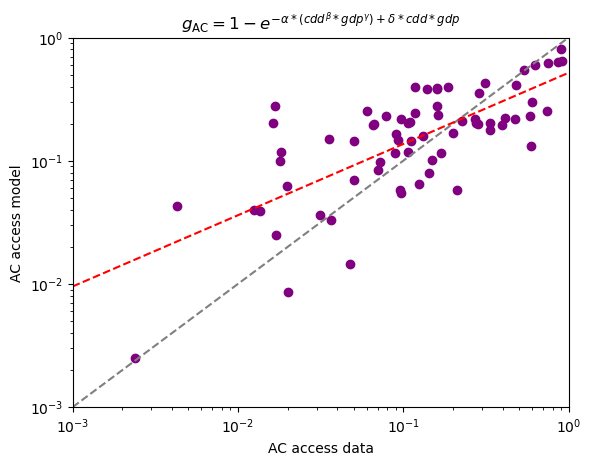

In [9]:
# Alternative fit function
ydata = (ac_data["AC"])
# Curve fit requiring all parameters to be positive
popt_comb, pcov_comb = curve_fit(ac_access_combined_exp, xdata, ydata, bounds=(0, np.inf))
print(popt_comb)

# Calculate the R^2 and RMSE value
calc_r2_rmse(ydata, ac_access_combined_exp(xdata, *popt_comb))
# Plot the AC access data vs model
# plot_ac_access((ydata), (ac_access_combined_exp(xdata, *popt_comb)), "purple", r"$f_{\mathrm{AC}}=1 - e^{-\alpha * (cdd^{\beta} * gdp^{\gamma})}$", "ac_access_combined_exp")

# with open('exposure_function_params_combined_exponential.pkl', 'wb') as f:
#     pickle.dump({'cdd_scale': popt_comb[0], 'alpha': popt_comb[1], 'k': popt_comb[2]}, f)

def ac_access_modified_exp(xdata, a, b, c, d):
    cdd, gdp = xdata
    return (1. - np.exp(-a * (cdd**b) * (gdp**c) + d * cdd * gdp))

# Alternative fit function
popt_mod, pcov_mod = curve_fit(ac_access_modified_exp, xdata, ydata, bounds=(0, np.inf))
print("\n")
print(popt_mod)
calc_r2_rmse(ydata, ac_access_modified_exp(xdata, *popt_mod))
plot_ac_access(ydata, ac_access_modified_exp(xdata, *popt_mod), "purple", r"$g_{\mathrm{AC}}=1 - e^{-\alpha * (cdd^{\beta} * gdp^{\gamma}) + \delta * cdd * gdp}$", "ac_access_modified_exp")

# Linear fit to data vs model in log space
def lin_funct(x, a, b):
    return a*x + b

#Drop negative values
ymodel = ac_access_modified_exp(xdata, *popt_mod)
ydata = ydata[ymodel > 0]
ymodel = ymodel[ymodel > 0]

popt_lin, pcov_lin = curve_fit(lin_funct, np.log(ydata), np.log(ymodel))
plt.plot([1e-3,1], np.exp(lin_funct(np.log([1e-3,1]), *popt_lin)), color='red', linestyle='--')

0.9331051625588678


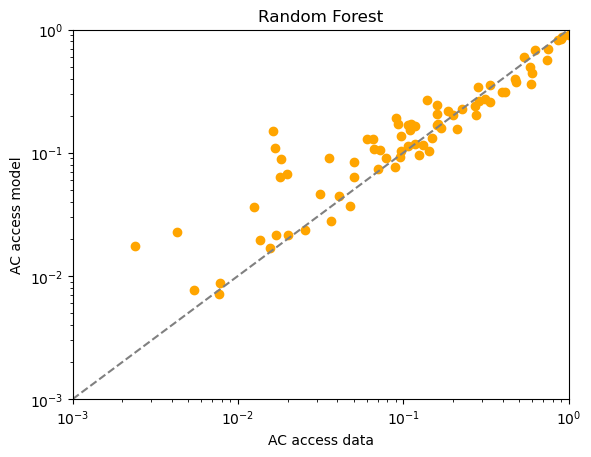

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Add artificial data point for saturation
artificial_data = pd.DataFrame({
    'CDD': [8000],
    'GDP': [500000],
    'AC': [1]
})

ac_data_mod = pd.concat([ac_data, artificial_data])
xdata_new = (ac_data_mod["CDD"]/1000., ac_data_mod["GDP"]/100000.)
xdata_scaled_back = np.vstack(xdata_new)
ydata = ac_data_mod["AC"]

# Initialize and fit a Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(xdata_scaled_back.T, ydata)

# Predict using the Random Forest model
y_pred_rf = rf.predict(xdata_scaled_back.T)

# Calculate R2 score for the Random Forest model
r2_rf = r2_score(ydata, y_pred_rf)

# Random Forest R2 score
print(r2_rf)

# Plot the Random Forest model
plot_ac_access(ydata, y_pred_rf, "orange", "Random Forest", "ac_access_rf")

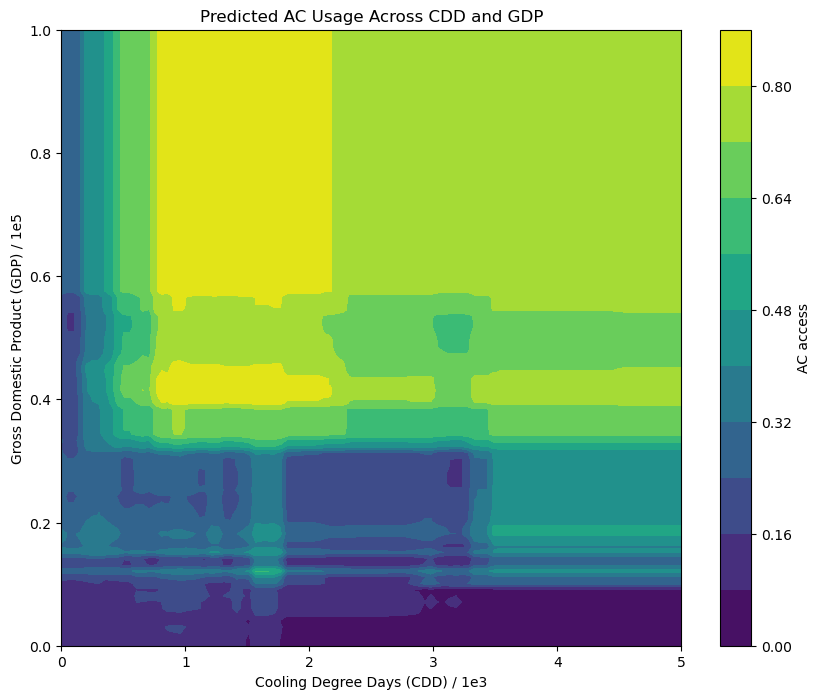

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.ensemble import RandomForestRegressor

# Assuming rf_full_model is your trained RandomForestRegressor
# Generate the CDD and GDP ranges
cdd_range = np.linspace(0, 5, 100)  # Adjusted for unit display
gdp_range = np.linspace(0, 1, 100)  # Adjusted for unit display

# Create a meshgrid for CDD and GDP
CDD, GDP = np.meshgrid(cdd_range, gdp_range)

# Flatten the grids to feed into the model
grid_to_predict = np.vstack([CDD.ravel(), GDP.ravel()]).T

# Predict using the random forest model
predictions = rf.predict(grid_to_predict)  # Ensure to use the correct model variable

# Reshape the predictions to fit the contour dimensions
predictions_reshaped = predictions.reshape(100, 100)

# Create the contour plot with normalized colors
plt.figure(figsize=(10, 8))
contour_plot = plt.contourf(cdd_range, gdp_range, predictions_reshaped, levels=11, cmap='viridis')
cbar = plt.colorbar(contour_plot, label='AC access')
plt.xlabel('Cooling Degree Days (CDD) / 1e3')
plt.ylabel('Gross Domestic Product (GDP) / 1e5')
plt.title('Predicted AC Usage Across CDD and GDP')
plt.show()
